In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import cv2
import matplotlib.pyplot as plt

Mounted at /content/drive


In [ ]:
from time import sleep

In [ ]:
# Without TQDM
s = 0
for i in range(10):
    s += i
    sleep(0.2)
print(s)

45


In [ ]:
# With TQDM
from tqdm import tqdm

s = 0
for i in tqdm(range(10)):
    s += i
    sleep(0.2)
print(s)

100%|██████████| 10/10 [00:02<00:00,  4.97it/s]

45


## Motivation


### Eigendecomposition

The **eigendecomposition** of some matrix $A$ is

$A = V \Lambda V^{-1}$

Where:

* As in examples above, $V$ is the concatenation of all the eigenvectors of $A$
* $\Lambda$ (upper-case $\lambda$) is the diagonal matrix diag($\lambda$). Note that the convention is to arrange the lambda values in descending order; as a result, the first eigenvalue (and its associated eigenvector) may be a primary characteristic of the matrix $A$.

In [ ]:
import numpy as np
import torch

In [88]:
A = np.array([[4, 2], [-5, -3]])
A

array([[ 4,  2],
       [-5, -3]])

In [89]:
lambdas, V = np.linalg.eig(A)

In [ ]:
V

array([[ 0.70710678, -0.37139068],
       [-0.70710678,  0.92847669]])

In [ ]:
Vinv = np.linalg.inv(V)
Vinv

array([[2.3570226 , 0.94280904],
       [1.79505494, 1.79505494]])

In [90]:
Lambda = np.diag(lambdas)
Lambda

array([[ 2.,  0.],
       [ 0., -1.]])

Confirm that $A = V \Lambda V^{-1}$:

In [91]:
np.dot(V, np.dot(Lambda, Vinv))

array([[ 4.,  2.],
       [-5., -3.]])

Eigendecomposition is not possible with all matrices. And in some cases where it is possible, the eigendecomposition involves complex numbers instead of straightforward real numbers.

In machine learning, however, we are typically working with real symmetric matrices, which can be conveniently and efficiently decomposed into real-only eigenvectors and real-only eigenvalues. If $A$ is a real symmetric matrix then...

$A = Q \Lambda Q^T$

...where $Q$ is analogous to $V$ from the previous equation except that it's special because it's an orthogonal matrix.

In [ ]:
A = np.array([[1, 2], [2, 1]])
A

array([[1, 2],
       [2, 1]])

In [ ]:
lambdas, Q = np.linalg.eig(A)

In [ ]:
lambdas

array([ 3., -1.])

In [ ]:
Lambda = np.diag(lambdas)
Lambda

array([[ 3.,  0.],
       [ 0., -1.]])

In [ ]:
Q

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

Let's confirm $A = Q \Lambda Q^T$:

In [ ]:
np.dot(Q, np.dot(Lambda, Q.T))

array([[1., 2.],
       [2., 1.]])

(As a quick aside, we can demostrate that $Q$ is an orthogonal matrix because $Q^TQ = QQ^T = I$.)

In [ ]:
np.dot(Q.T, Q)

array([[1.00000000e+00, 2.23711432e-17],
       [2.23711432e-17, 1.00000000e+00]])

In [ ]:
np.dot(Q, Q.T)

array([[ 1.00000000e+00, -2.23711432e-17],
       [-2.23711432e-17,  1.00000000e+00]])

**Exercises**:

1. Use PyTorch to decompose the matrix $P$ (below) into its components $V$, $\Lambda$, and $V^{-1}$. Confirm that $P = V \Lambda V^{-1}$.
2. Use PyTorch to decompose the symmetric matrix $S$ (below) into its components $Q$, $\Lambda$, and $Q^T$. Confirm that $S = Q \Lambda Q^T$.

In [ ]:
P = torch.tensor([[25, 2, -5], [3, -2, 1], [5, 7, 4.]])
P

tensor([[25.,  2., -5.],
        [ 3., -2.,  1.],
        [ 5.,  7.,  4.]])

In [ ]:
S = torch.tensor([[25, 2, -5], [2, -2, 1], [-5, 1, 4.]])
S

tensor([[25.,  2., -5.],
        [ 2., -2.,  1.],
        [-5.,  1.,  4.]])


### Singular Value Decomposition (SVD)
==================================


Previously, we explored a class of vectors whose directions were left unchanged by a matrix. We found that, for any **square** matrix, if there existed $n$ linearly independent eigenvectors, we could diagonalize $\bf A$ into the form  $\bf{AX = XD} $, where  $\bf X $ is a basis of  $\mathbb{R}^n $, where  $\bf{Ax_i = \lambda_ix_i} $.

A more general factorization is, for **any**  $m \times n $ matrix, there exists a singular value decomposition in the form  $\bf{AV = U{\Sigma}} $ or  $\bf{A=U{\Sigma}V^T} $. To result in this composition, we require  $\bf U $ as an orthogonal basis of  $\mathbb{R}^m $,  $\bf V $ as an orthogonal basis of  $\mathbb{R}^n $, and  $\bf{\Sigma} $ as an  $m \times n $ diagonal matrix, where  $\bf{Av_i = \sigma_iu_i} $.

*    $\bf U $ is composed of the eigenvectors of  $\bf{AA^T} $ as its columns.
*    $\bf V $ is composed of the eigenvectors of  $\bf{A^TA} $ as its columns.
*    $\bf \Sigma $ is a diagonal matrix composed of square roots of the eigenvalues of  $\bf{A^TA} $ (or  $\bf{AA^T} $), called singular values.
*    $\bf{A^TA} $ and  $\bf{AA^T} $ have the same positive eigenvalues, so the square roots of the eigenvalues are also the same.
*   The diagonal of  $\bf \Sigma $ is ordered by non-increasing singular values and the columns of  $\bf U $,  $\bf V $ are ordered respectively.

In addition, we define a reduced form:  ${\bf A} = {\bf U_{R}} {\bf \Sigma_{R}} {\bf V_R}^T $ where  ${\bf U_R} $ is an  $m \times k $ matrix,  ${\bf V_R} $ is an  $n \times k $ matrix, and  ${\bf \Sigma_{R}} $ is an  $k \times k $ diagonal matrix. Here,  $k = \min(m,n) $.


Singular Value Decomposition
----------------------------

An  $m \times n $ real matrix  ${\bf A} $ has a singular value decomposition of the form

\\[{\bf A} = {\bf U} {\bf \Sigma} {\bf V}^T\\]

where  ${\bf U} $ is an  $m \times m $ orthogonal matrix,  ${\bf V} $ is an  $n \times n $ orthogonal matrix, and  ${\bf \Sigma} $ is an  $m \times n $ diagonal matrix. Specifically,

*    ${\bf U} $ is an  $m \times m $ orthogonal matrix whose columns are eigenvectors of  ${\bf A} {\bf A}^T $, called the **left singular vectors** of  ${\bf A} $.

\\[\mathbf{A}\mathbf{A}^T = ({\bf U} {\bf \Sigma} {\bf V}^T)({\bf U} {\bf \Sigma} {\bf V}^T)^T\\] \\[\hspace{2cm} ({\bf U} {\bf \Sigma} {\bf V}^T) ({\bf V}^T)^T {\bf \Sigma}^T {\bf U}^T = {\bf U} {\bf \Sigma} ({\bf V}^T {\bf V}) {\bf \Sigma}^T {\bf U}^T = {\bf U} ({\bf \Sigma} {\bf \Sigma}^T) {\bf U}^T\\]

Hence,  $\bf{AA^T=U\Sigma^2U^T} $, which is a diagonalization, where the columns of U are linearly independent.

*    ${\bf V} $ is an  $n \times n $ orthogonal matrix whose columns are eigenvectors of  ${\bf A}^T {\bf A} $, called the **right singular vectors** of  ${\bf A} $.

\\[\mathbf{A}^T\mathbf{A} = ({\bf U} {\bf \Sigma} {\bf V}^T)^T ({\bf U} {\bf \Sigma} {\bf V}^T)\\] \\[= {\bf V} ({\bf \Sigma}^T {\bf \Sigma}) {\bf V}^T\\]

Hence,  $\bf{A^TA=V\Sigma^2V^T} $, which is a diagonalization, where the columns of V are linearly independent.

*    ${\bf \Sigma} $ is an  $m \times n $ diagonal matrix, composed of the square root of the eigenvalues of  $A^TA $, in the form:

\\[\begin{eqnarray} {\bf \Sigma} = \begin{bmatrix} \sigma_1 & & \\ & \ddots & \\ & & \sigma_s \\ 0 & & 0 \\ \vdots & \ddots & \vdots \\ 0 & & 0 \end{bmatrix} \text{when } m > n, \; \text{and} \; {\bf \Sigma} = \begin{bmatrix} \sigma_1 & & & 0 & \dots & 0 \\ & \ddots & & & \ddots &\\ & & \sigma_s & 0 & \dots & 0 \\ \end{bmatrix} \text{when} \, m < n. \end{eqnarray}\\]

where  $k = \min(m,n) $ and  $\sigma_1 \ge \sigma_2 \dots \ge \sigma_s \ge 0 $. The diagonal entries are called the _singular_ values of  ${\bf A} $.

#### Obtaining Singular Values

Note that the matrices  $\bf{A^TA} $ and  $\bf{AA^T} $ always have the same non-zero eigenvalues. In addition, they are both positive semi-definite (defined:  $\mathbf{x^{T}Bx} \geq 0 \quad \forall \mathbf{x} \neq 0 $). As the eigenvalues of positive semi-definite matrices are always non-negative, **singular values are always non-negative**.

If  $\mathbf{A}^T\mathbf{x} \ne 0 $, then  $\mathbf{A}^T\mathbf{A} $ and  $\mathbf{A}\mathbf{A}^T $ both have the same eigenvalues:

\\[\mathbf{A}\mathbf{A}^T\mathbf{x} = \lambda \mathbf{x}\\] \\[\mathbf{A}^T\mathbf{A}\mathbf{A}^T\mathbf{x} = \mathbf{A}^T \lambda \mathbf{x}\\] \\[\mathbf{A}^T\mathbf{A}(\mathbf{A}^T\mathbf{x}) = \lambda (\mathbf{A}^T\mathbf{x})\\]

Time Complexity
---------------

The time-complexity for computing the SVD factorization of an arbitrary  $m \times n $ matrix is $\mathcal{O}(m^2n + n^3) $


Reduced SVD
-----------

The SVD factorization of a non-square matrix  ${\bf A} $ of size  $m \times n $ can be represented in a reduced format:

*   For  $m \ge n $:  ${\bf U} $ is  $m \times n $,  ${\bf \Sigma} $ is  $n \times n $, and  ${\bf V} $ is  $n \times n $
*   For  $m \le n $:  ${\bf U} $ is  $m \times m $,  ${\bf \Sigma} $ is  $m \times m $, and  ${\bf V} $ is  $n \times m $ (note if  ${\bf V} $ is  $n \times m $, then  ${\bf V}^T $ is  $m \times n $)


In general, we will represent the reduced SVD as:

\\[{\bf A} = {\bf U}_R {\bf \Sigma}_R {\bf V}_R^T\\]

where  ${\bf U}_R $ is a  $m \times k $ matrix,  ${\bf V}_R $ is a  $n \times k $ matrix,  ${\bf \Sigma}_R $ is a  $k \times k $ matrix, and  $k = \min(m,n) $.

Example: Computing the SVD
--------------------------

We begin with the following non-square matrix,  ${\bf A} $

\\[ {\bf A} = \left[ \begin{array}{ccc} 3 & 2 & 3 \\ 8 & 8 & 2 \\ 8 & 7 & 4 \\ 1 & 8 & 7 \\ 6 & 4 & 7 \\ \end{array} \right] \\]

and we will compute the reduced form of the SVD (where here  $s = 3 $):

(1) Compute  ${\bf A}^T {\bf A} $:

\\[{\bf A}^T {\bf A} = \left[ \begin{array}{ccc} 174 & 158 & 106 \\ 158 & 197 & 134 \\ 106 & 134 & 127 \\ \end{array} \right]\\]

(2) Compute the eigenvectors and eigenvalues of  ${\bf A}^T {\bf A} $:

\\[\lambda_1 = 437.479, \quad \lambda_2 = 42.6444, \quad \lambda_3 = 17.8766, \\ \boldsymbol{v}_1 = \begin{bmatrix} 0.585051 \\ 0.652648 \\ 0.481418\end{bmatrix}, \quad \boldsymbol{v}_2 = \begin{bmatrix} -0.710399 \\ 0.126068 \\ 0.692415 \end{bmatrix}, \quad \boldsymbol{v}_3 = \begin{bmatrix} 0.391212 \\ -0.747098 \\ 0.537398 \end{bmatrix}\\]

(3) Construct  ${\bf V}_R $ from the eigenvectors of  ${\bf A}^T {\bf A} $:

\\[ {\bf V}_R = \left[ \begin{array}{ccc} 0.585051 & -0.710399 & 0.391212 \\ 0.652648 & 0.126068 & -0.747098 \\ 0.481418 & 0.692415 & 0.537398 \\ \end{array} \right]. \\]

(4) Construct  ${\bf \Sigma}_R $ from the square roots of the eigenvalues of  ${\bf A}^T {\bf A} $:

\\[ {\bf \Sigma}_R = \begin{bmatrix} 20.916 & 0 & 0 \\ 0 & 6.53207 & 0 \\ 0 & 0 & 4.22807 \end{bmatrix} \\]

(5) Find  ${\bf U} $ by solving  ${\bf U}{\bf\Sigma} = {\bf A}{\bf V} $. For our reduced case, we can find  ${\bf U}_R = {\bf A}{\bf V}_R {\bf \Sigma}_R^{-1} $. You could also find  ${\bf U} $ by computing the eigenvectors of  ${\bf AA}^T $.

\\[{\bf U} = \overbrace{\left[ \begin{array}{ccc} 3 & 2 & 3 \\ 8 & 8 & 2 \\ 8 & 7 & 4 \\ 1 & 8 & 7 \\ 6 & 4 & 7 \\ \end{array} \right]}^{A} \overbrace{\left[ \begin{array}{ccc} 0.585051 & -0.710399 & 0.391212 \\ 0.652648 & 0.126068 & -0.747098 \\ 0.481418 & 0.692415 & 0.537398 \\ \end{array} \right]}^{V} \overbrace{\left[ \begin{array}{ccc} 0.047810 & 0.0 & 0.0 \\ 0.0 & 0.153133 & 0.0 \\ 0.0 & 0.0 & 0.236515 \\ \end{array} \right]}^{\Sigma^{-1}}\\] \\[{\bf U} = \left[ \begin{array}{ccc} 0.215371 & 0.030348 & 0.305490 \\ 0.519432 & -0.503779 & -0.419173 \\ 0.534262 & -0.311021 & 0.011730 \\ 0.438715 & 0.787878 & -0.431352\\ 0.453759 & 0.166729 & 0.738082\\ \end{array} \right]\\]

We obtain the following singular value decomposition for  ${\bf A} $:

\\[ \overbrace{\left[ \begin{array}{ccc} 3 & 2 & 3 \\ 8 & 8 & 2 \\ 8 & 7 & 4 \\ 1 & 8 & 7 \\ 6 & 4 & 7 \\ \end{array} \right]}^{A} = \overbrace{\left[ \begin{array}{ccc} 0.215371 & 0.030348 & 0.305490 \\ 0.519432 & -0.503779 & -0.419173 \\ 0.534262 & -0.311021 & 0.011730 \\ 0.438715 & 0.787878 & -0.431352\\ 0.453759 & 0.166729 & 0.738082\\ \end{array} \right]}^{U} \overbrace{\left[ \begin{array}{ccc} 20.916 & 0 & 0 \\ 0 & 6.53207 & 0 \\ 0 & 0 & 4.22807 \\ \end{array} \right]}^{\Sigma} \overbrace{\left[ \begin{array}{ccc} 0.585051 & 0.652648 & 0.481418 \\ -0.710399 & 0.126068 & 0.692415\\ 0.391212 & -0.747098 & 0.537398\\ \end{array} \right]}^{V^T} \\]

Recall that we computed the _reduced_ SVD factorization (i.e.  ${\bf \Sigma} $ is square,  ${\bf U} $ is non-square) here.

Rank, null space and range of a matrix
--------------------------------------

Suppose  ${\bf A} $ is a  $m \times n $ matrix where  $m > n $ (without loss of generality):

\\[{\bf A}= {\bf U\Sigma V}^{T} = \begin{bmatrix}\vert & & \vert & & \vert \\ \vert & & \vert & & \vert \\ {\bf u}_1 & \cdots & {\bf u}_n & \cdots & {\bf u}_m\\ \vert & & \vert & & \vert \\\vert & & \vert & & \vert \end{bmatrix} \begin{bmatrix} \sigma_1 & & \\ & \ddots & \\ & & \sigma_n \\ & \vdots & \\ -& 0& -\end{bmatrix} \begin{bmatrix} - & {\bf v}_1^T & - \\ & \vdots & \\ - & {\bf v}_n^T & - \end{bmatrix}\\]

We can re-write the above as:

\\[{\bf A} = \begin{bmatrix}\vert & & \vert \\ \vert & & \vert \\ {\bf u}_1 & \cdots & {\bf u}_n \\ \vert & & \vert \\ \vert & & \vert \end{bmatrix} \begin{bmatrix} - & \sigma_1 {\bf v}_1^T & - \\ & \vdots & \\ - & \sigma_n{\bf v}_n^T & - \end{bmatrix}\\]

Furthermore, the product of two matrices can be written as a sum of outer products:

\\[{\bf A} = \sigma_1 {\bf u}_1 {\bf v}_1^T + \sigma_2 {\bf u}_2 {\bf v}_2^T + ... + \sigma_n {\bf u}_n {\bf v}_n^T\\]

For a general rectangular matrix, we have:

\\[{\bf A} = \sum_{i=1}^{s} \sigma_i {\bf u}_i {\bf v}_i^T\\]

where  $s = \min(m,n) $.

If  ${\bf A} $ has  $s $ non-zero singular values, the matrix is full rank, i.e.  $\text{rank}({\bf A}) = s $.

If  ${\bf A} $ has  $r $ non-zero singular values, and  $r < s $, the matrix is rank deficient, i.e.  $\text{rank}({\bf A}) = r $.

In other words, the rank of  ${\bf A} $ equals the number of non-zero singular values which is the same as the number of non-zero diagonal elements in  ${\bf \Sigma} $.

Rounding errors may lead to small but non-zero singular values in a rank deficient matrix. Singular values that are smaller than a given tolerance are assumed to be numerically equivalent to zero, defining what is sometimes called the effective rank.

The right-singular vectors (columns of  ${\bf V} $) corresponding to vanishing singular values of  ${\bf A} $ span the null space of  ${\bf A} $, i.e. null( ${\bf A} $) = span{ ${\bf v}_{r+1} $,  ${\bf v}_{r+2} $, …,  ${\bf v}_{n} $}.

The left-singular vectors (columns of  ${\bf U} $) corresponding to the non-zero singular values of  ${\bf A} $ span the range of  ${\bf A} $, i.e. range( ${\bf A} $) = span{ ${\bf u}_{1} $,  ${\bf u}_{2} $, …,  ${\bf u}_{r} $}.

#### Example:

\\[{\bf A} = \left[ \begin{array}{cccc} \frac{1}{\sqrt{2}} & -\frac{1}{\sqrt{2}} & 0 & 0 \\ \frac{1}{\sqrt{2}}2 &\frac{1}{\sqrt{2}} & 0 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & 1 & 0 \end{array} \right] \left[ \begin{array}{ccc} 14 & 0 & 0 \\ 0 & 14 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 0 \end{array} \right] \left[ \begin{array}{ccc} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{array} \right]\\]

The rank of  ${\bf A} $ is 2.

The vectors  $\left[ \begin{array}{c} \frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}} \\ 0 \\ 0 \end{array} \right] $ and  $\left[ \begin{array}{c} -\frac{1}{\sqrt{2}} \\ \frac{1}{\sqrt{2}} \\ 0 \\ 0 \end{array} \right] $ provide an orthonormal basis for the range of  ${\bf A} $.

The vector  $\left[ \begin{array}{c} 0 \\ 0\\ 1 \end{array} \right] $ provides an orthonormal basis for the null space of  ${\bf A} $.

(Moore-Penrose) Pseudoinverse
-----------------------------

If the matrix  ${\bf \Sigma} $ is rank deficient, we cannot get its inverse. We define instead the pseudoinverse:

\\[({\bf \Sigma}^+)_{ii} = \begin{cases} \frac{1}{\sigma_i} & \sigma_i \neq 0\\ 0 & \sigma_i = 0 \end{cases}\\]

For a general non-square matrix  ${\bf A} $ with known SVD ( ${\bf A} = {\bf U\Sigma V}^T $), the pseudoinverse is defined as:

\\[{\bf A}^{+} = {\bf V\Sigma}^{+}{\bf U}^T\\]

For example, if we consider a  $m \times n $ full rank matrix where  $m > n $:

\\[{\bf A}^{+}= \begin{bmatrix} \vert & ... & \vert \\ {\bf v}_1 & ... & {\bf v}_n\\ \vert & ... & \vert \end{bmatrix} \begin{bmatrix} 1/\sigma_1 & & & 0 & \dots & 0 \\ & \ddots & & & \ddots &\\ & & 1/\sigma_n & 0 & \dots & 0 \\ \end{bmatrix} \begin{bmatrix}\vert & & \vert & & \vert \\ \vert & & \vert & & \vert \\ {\bf u}_1 & \cdots & {\bf u}_n & \cdots & {\bf u}_m\\ \vert & & \vert & & \vert \\\vert & & \vert & & \vert \end{bmatrix}^T\\]

Euclidean norm of matrices
--------------------------

The induced 2-norm of a matrix  ${\bf A} $ can be obtained using the SVD of the matrix :

\\[\begin{align} \| {\bf A} \|_2 &= \max_{\|\mathbf{x}\|=1} \|\mathbf{A x}\| = \max_{\|\mathbf{x}\|=1} \|\mathbf{U \Sigma V}^T {\bf x}\| \\ & =\max_{\|\mathbf{x}\|=1} \|\mathbf{ \Sigma V}^T {\bf x}\| = \max_{\|\mathbf{V}^T{\bf x}\|=1} \|\mathbf{ \Sigma V}^T {\bf x}\| =\max_{\|y\|=1} \|\mathbf{ \Sigma} y\| \end{align}\\]

And hence,

\\[\| {\bf A} \|_2= \sigma_1\\]

In the above equations, all the notations for the norm  $\| . \| $ refer to the  $p=2 $ Euclidean norm, and we used the fact that  ${\bf U} $ and  ${\bf V} $ are orthogonal matrices and hence  $\|{\bf U}\|_2 = \|{\bf V}\|_2 = 1 $.

#### Example:

We begin with the following non-square matrix  ${\bf A} $:

\\[{\bf A} = \left[ \begin{array}{ccc} 3 & 2 & 3 \\ 8 & 8 & 2 \\ 8 & 7 & 4 \\ 1 & 8 & 7 \\ 6 & 4 & 7 \\ \end{array} \right].\\]

The matrix of singular values,  ${\bf \Sigma} $, computed from the SVD factorization is:

\\[ \Sigma = \left[ \begin{array}{ccc} 20.916 & 0 & 0 \\ 0 & 6.53207 & 0 \\ 0 & 0 & 4.22807 \\ \end{array} \right]. \\]

Consequently the 2-norm of  ${\bf A} $ is

\\[ \|{\bf A}\|_2 = 20.916.\\]

Euclidean norm of the inverse of matrices
-----------------------------------------

Following the same derivation as above, we can show that for a full rank  $n \times n $ matrix we have:

\\[\| {\bf A}^{-1} \|_2= \frac{1}{\sigma_n}\\]

where  ${\sigma_n} $ is the smallest singular value.

For non-square matrices, we can use the definition of the pseudoinverse (regardless of the rank):

\\[\| {\bf A}^{+} \|_2= \frac{1}{\sigma_r}\\]

where  ${\sigma_r} $ is the smallest **non-zero** singular value. Note that for a full rank square matrix, we have  $\| {\bf A}^{+} \|_2 = \| {\bf A}^{-1} \|_2 $. An exception of the definition above is the zero matrix. In this case,  $\| {\bf A}^{+} \|_2 = 0 $

2-Norm Condition Number
-----------------------

The 2-norm condition number of a matrix  ${\bf A} $ is given by the ratio of its largest singular value to its smallest singular value:

\\[\text{cond}_2(A) = \|{\bf A}\|_2 \|{\bf A}^{-1}\|_2 = \sigma_{\max}/\sigma_{\min}.\\]

If the matrix  ${\bf A} $ is rank deficient, i.e.  $\text{rank}({\bf A}) < \min(m,n) $, then  $\text{cond}_2({\bf A}) = \infty $.

Low-rank Approximation
----------------------

The best rank- $k $ approximation for a  $m \times n $ matrix  ${\bf A} $, where  $k < s = \min(m,n) $, for some matrix norm  $\|.\| $, is one that minimizes the following problem:

\\[\begin{aligned} &\min_{ {\bf A}_k } \ \|{\bf A} - {\bf A}_k\| \\ &\textrm{such that} \quad \mathrm{rank}({\bf A}_k) \le k. \end{aligned}\\]

Under the induced  $2 $\-norm, the best rank- $k $ approximation is given by the sum of the first  $k $ outer products of the left and right singular vectors scaled by the corresponding singular value (where,  $\sigma_1 \ge \dots \ge \sigma_s $):

\\[{\bf A}_k = \sigma_1 \bf{u}_1 \bf{v}_1^T + \dots \sigma_k \bf{u}_k \bf{v}_k^T\\]

Observe that the norm of the difference between the best approximation and the matrix under the induced  $2 $\-norm condition is the magnitude of the  $(k+1)^\text{th} $ singular value of the matrix:

\\[\|{\bf A} - {\bf A}_k\|_2 = \left|\left|\sum_{i=k+1}^n \sigma_i \bf{u}_i \bf{v}_i^T\right|\right|_2 = \sigma_{k+1}\\]

Note that the best rank- ${k} $ approximation to  ${\bf A} $ can be stored efficiently by only storing the  ${k} $ singular values  ${\sigma_1,\dots,\sigma_k} $, the  ${k} $ left singular vectors  ${\bf u_1,\dots,\bf u_k} $, and the  ${k} $ right singular vectors  ${\bf v_1,\dots, \bf v_k} $.


Using SVD to solve a square system of linear equations
------------------------------------------------------

If  $\bf A $ is an  $n \times n $ square matrix and we want to solve  $\bf{Ax=b} $, we can use the SVD for A such that

\\[\bf{U{\Sigma}V^Tx=b}\\] \\[\bf{ {\Sigma} V^Tx=U^Tb}\\]

Solve:  $\bf{\Sigma y=U^Tb} $ (diagonal matrix, easy to solve)

Evaluate:  $\bf{x=Vy} $

*   Cost of solve:  $O(n^2) $
*   Cost of decomposition  $O(n^3) $. Recall that SVD and LU have the same asymptotic behavior, however the number of operations - the constant factor before the  $n^3 $ - for the SVD is larger.
  

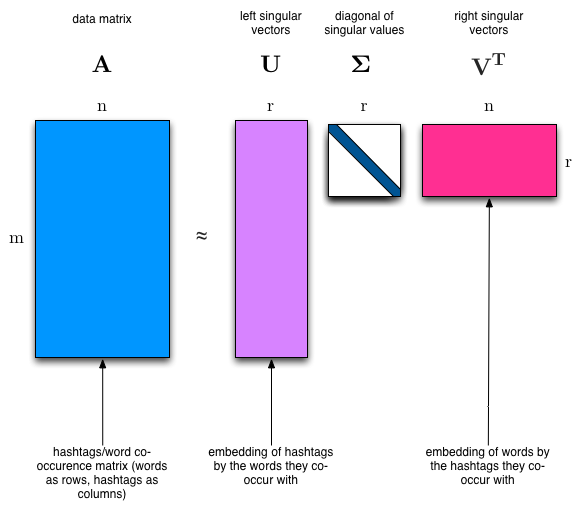

In [ ]:
from IPython.display import Image, display

# Replace 'path/to/your/image.jpg' with the actual path to your image
image_path = '/content/drive/MyDrive/Teaching/Math391/svd_fb.png'
display(Image(filename=image_path))

In [ ]:
A = np.array([[-1, 2], [3, -2], [5, 7]])
A

array([[-1,  2],
       [ 3, -2],
       [ 5,  7]])

In [ ]:
U, d, VT = np.linalg.svd(A) # V is already transposed

In [ ]:
U

array([[ 0.12708324,  0.47409506,  0.87125411],
       [ 0.00164602, -0.87847553,  0.47778451],
       [ 0.99189069, -0.0592843 , -0.11241989]])

In [ ]:
VT

array([[ 0.55798885,  0.82984845],
       [-0.82984845,  0.55798885]])

In [ ]:
d

array([8.66918448, 4.10429538])

In [ ]:
np.diag(d)

array([[8.66918448, 0.        ],
       [0.        , 4.10429538]])

$D$ must have the same dimensions as $A$ for $UDV^T$ matrix multiplication to be possible:

In [ ]:
D = np.concatenate((np.diag(d), [[0, 0]]), axis=0)
D

array([[8.66918448, 0.        ],
       [0.        , 4.10429538],
       [0.        , 0.        ]])

In [ ]:
np.dot(U, np.dot(D, VT))

array([[-1.,  2.],
       [ 3., -2.],
       [ 5.,  7.]])

### Image Compression via SVD

In [ ]:
from PIL import Image

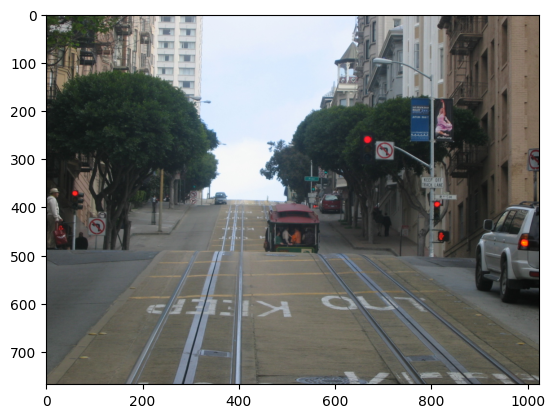

In [ ]:
img = Image.open('/content/drive/MyDrive/Teaching/Math391/SanFranciscoStreet.jpg')
_ = plt.imshow(img)

Convert image to grayscale so that we don't have to deal with the complexity of multiple color channels:

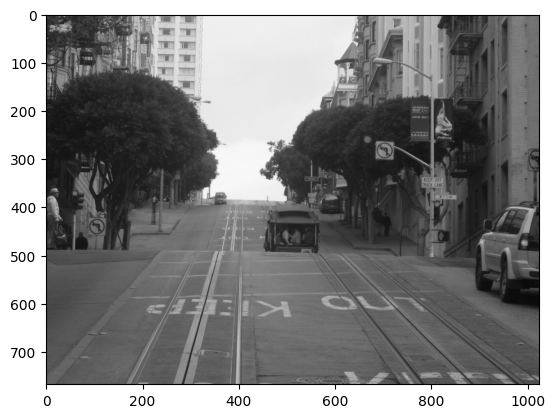

In [ ]:
imggray = img.convert('LA')
_ = plt.imshow(imggray)

Convert data into numpy matrix, which doesn't impact image data:

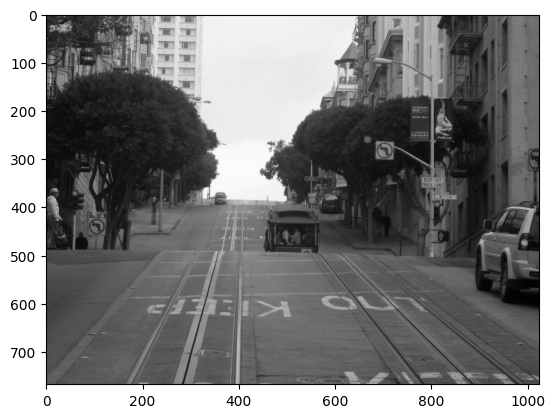

In [ ]:
imgmat = np.array(list(imggray.getdata(band=0)), float)
imgmat.shape = (imggray.size[1], imggray.size[0])
imgmat = np.matrix(imgmat)
_ = plt.imshow(imgmat, cmap='gray')

Calculate SVD of the image:

In [ ]:
U, Sigma, V = np.linalg.svd(imgmat)

As eigenvalues are arranged in descending order in diag($\lambda$) so too are singular values, by convention, arranged in descending order in $D$ (or, in this code, diag($\Sigma$)). Thus, the first left-singular vector of $U$ and first right-singular vector of $V$ may represent the most prominent feature of the image:

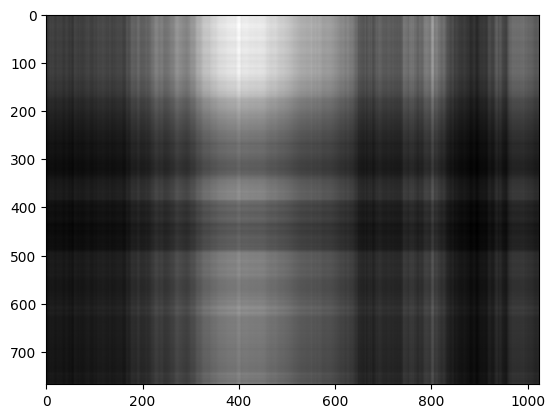

In [ ]:
reconstimg = np.matrix(U[:, :1]) * np.diag(Sigma[:1]) * np.matrix(V[:1, :])
_ = plt.imshow(reconstimg, cmap='gray')

Additional singular vectors improve the image quality:

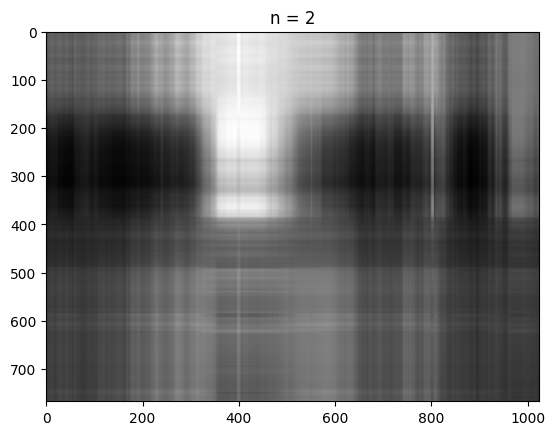

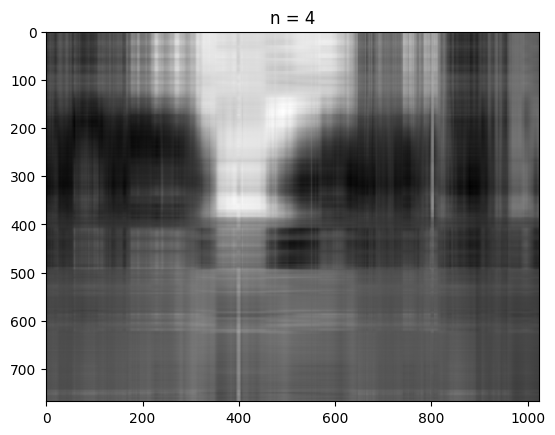

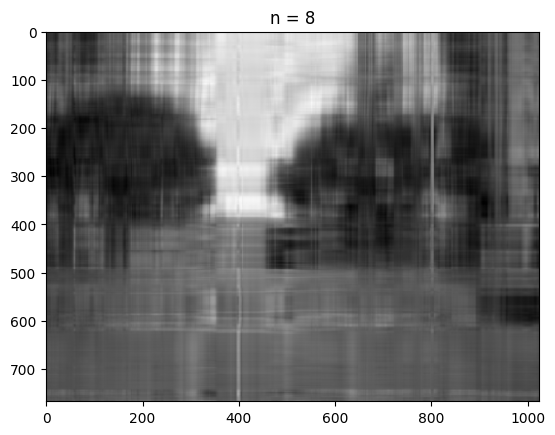

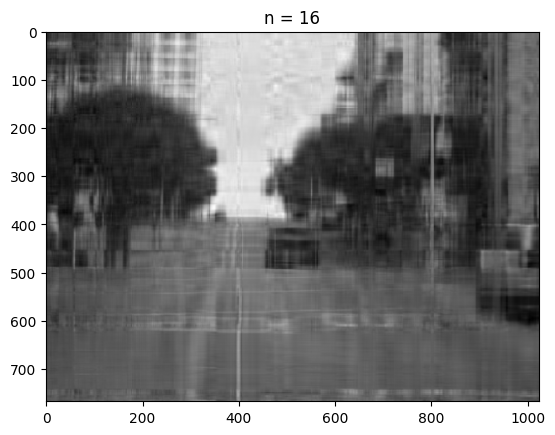

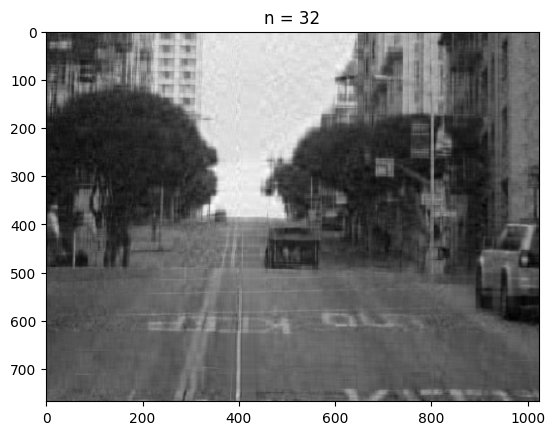

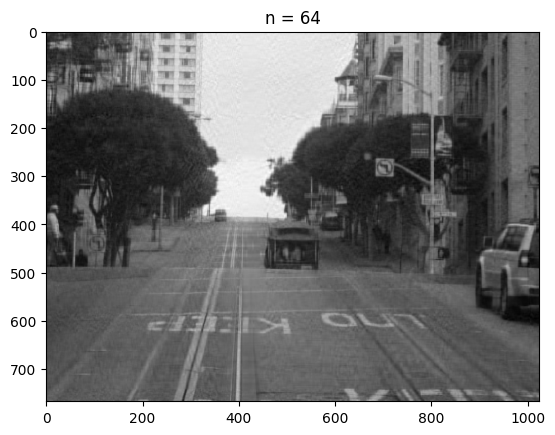

In [ ]:
for i in [2, 4, 8, 16, 32, 64]:
    reconstimg = np.matrix(U[:, :i]) * np.diag(Sigma[:i]) * np.matrix(V[:i, :])
    plt.imshow(reconstimg, cmap='gray')
    title = "n = %s" % i
    plt.title(title)
    plt.show()

With 64 singular vectors, the image is reconstructed quite well, however the data footprint is much smaller than the original image:

In [ ]:
imgmat.shape

(768, 1024)

In [ ]:
full_representation = 4032*3024
full_representation

12192768

In [ ]:
svd64_rep = 64*4032 + 64 + 64*3024
svd64_rep

451648

In [ ]:
svd64_rep/full_representation

0.037042286050222556

Specifically, the image represented as 64 singular vectors is 3.7% of the size of the original!

Alongside images, we can use singular vectors for dramatic, lossy compression of other types of media files.

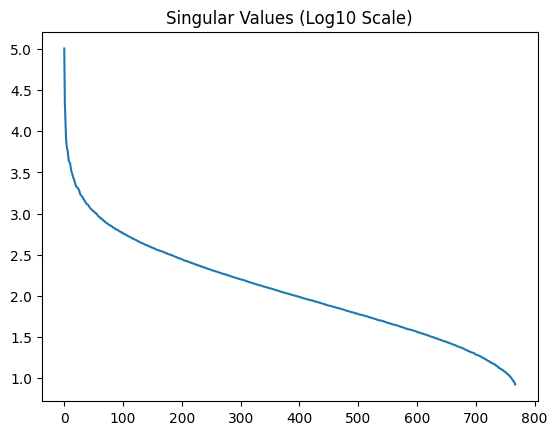

In [ ]:
# Plot the magnitude of the singular values (log scale)
plt.plot(np.log10(Sigma)); plt.title('Singular Values (Log10 Scale)');

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
/tmp/ipython-input-2856067831.py:1: SyntaxWarning: invalid escape sequence '\S'
  plt.plot(np.cumsum(Sigma) / sum(Sigma)); plt.title('Cumulative Percent of Total \Sigmas');


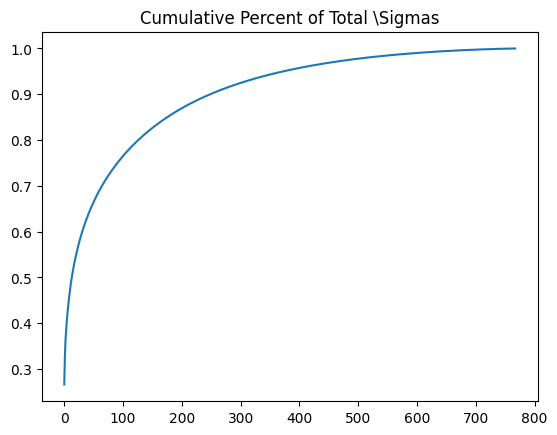

In [ ]:
plt.plot(np.cumsum(Sigma) / sum(Sigma)); plt.title('Cumulative Percent of Total \Sigmas');

# 3. Background Removal with Robust PCA

We use the real video: Human Activity Video Datasets:

Import needed libraries:

In [ ]:
import moviepy.editor as mpe
# from IPython.display import display
from glob import glob

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':



In [ ]:
import sys, os
import numpy as np
import scipy

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
# MAX_ITERS = 10
TOL = 1.0e-8

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import cv2

video = mpe.VideoFileClip("/content/drive/MyDrive/Teaching/Math391/Video_003.avi")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
video.subclip(0,50).ipython_display(width=300)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
video.duration

113.57

### Helper Methods

In [ ]:
from PIL import Image

In [ ]:
def create_data_matrix_from_video(clip, k=5, scale = (160,120)):
  return np.vstack([np.array(Image.fromarray(rgb2gray(clip.get_frame(i/float(k))).astype(np.uint8)).resize(scale)).flatten()
                   for i in range(k * int(clip.duration))]).T
  #return np.vstack([scipy.misc.imresize(rgb2gray(clip.get_frame(i/float(k))).astype(int), scale).flatten() for i in range(k * int(clip.duration))]).T

In [ ]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [ ]:
def plt_images(M, A, E, index_array, dims, filename=None):
    f = plt.figure(figsize=(15, 10))
    r = len(index_array)
    pics = r * 3
    for k, i in enumerate(index_array):
        for j, mat in enumerate([M, A, E]):
            sp = f.add_subplot(r, 3, 3*k + j + 1)
            sp.axis('Off')
            pixels = mat[:,i]
            if isinstance(pixels, scipy.sparse.csr_matrix):
                pixels = pixels.todense()
            plt.imshow(np.reshape(pixels, dims), cmap='gray')
    return f

In [ ]:
def plots(ims, dims, figsize=(15,20), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims)
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        plt.imshow(np.reshape(ims[i], dims), cmap="gray")

### Load and view the data

An image from 1 moment in time is 60 pixels by 80 pixels (when scaled). We can *unroll* that picture into a single tall column. So instead of having a 2D picture that is $60 \times 80$, we have a $1 \times 4,800$ column

This isn't very human-readable, but it's handy because it lets us stack the images from different times on top of one another, to put a video all into 1 matrix.  If we took the video image every tenth of a second for 113 seconds (so 11,300 different images, each from a different point in time), we'd have a $11300 \times 4800$ matrix, representing the video!

In [ ]:
scale = 25   # Adjust scale to change resolution of image
dims = (int(240 * (scale/100)), int(320 * (scale/100)))

In [ ]:
M = create_data_matrix_from_video(video, 100, (80, 60))
# M = create_data_matrix_from_video(video, 100, scale)
# M = np.load("high_res_surveillance_matrix.npy")

In [ ]:
print(dims, M.shape)

(60, 80) (4800, 11300)


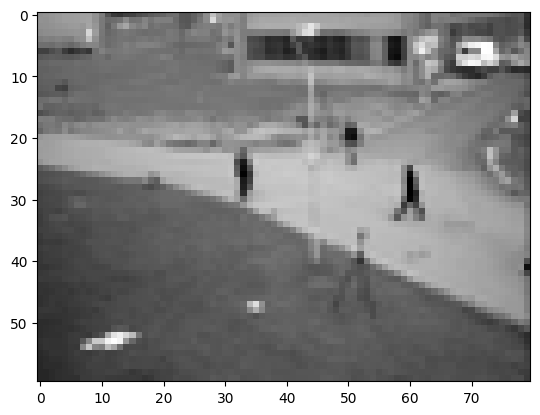

In [ ]:
plt.imshow(np.reshape(M[:,140], dims), cmap='gray');

Since `create_data_from_matrix` is somewhat slow, we will save our matrix.  In general, whenever you have slow pre-processing steps, it's a good idea to save the results for future use.

In [ ]:
np.save("low_res_surveillance_matrix.npy", M)

Note: High-res M is too big to plot, so only run the below with the low-res version

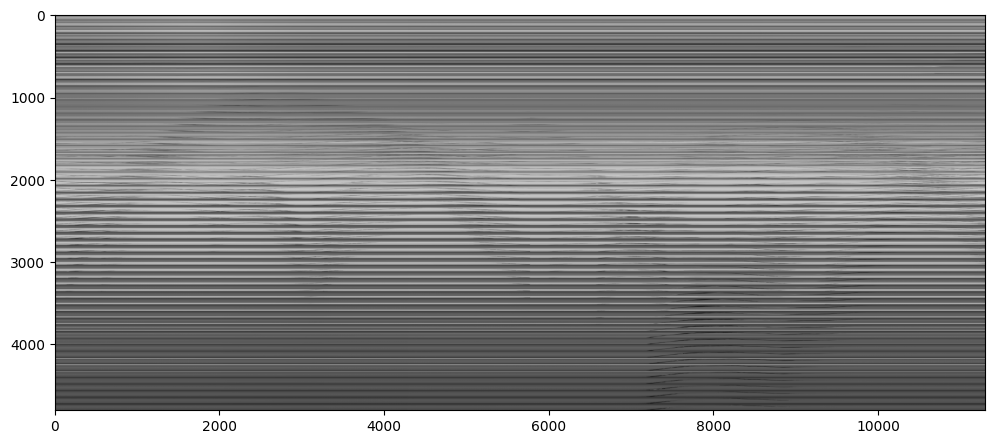

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(M, cmap='gray')

**Questions**: What are those wavy black lines?  What are the horizontal lines?

In [ ]:
plt.imsave(fname="image1.jpg", arr=np.reshape(M[:,140], dims), cmap='gray')

## SVD

### A first attempt with SVD

In [ ]:
from sklearn import decomposition

In [ ]:
u, s, v = decomposition.randomized_svd(M, 2)

In [ ]:
u.shape, s.shape, v.shape

((4800, 2), (2,), (2, 11300))

In [ ]:
low_rank = u @ np.diag(s) @ v

In [ ]:
low_rank.shape

(4800, 11300)

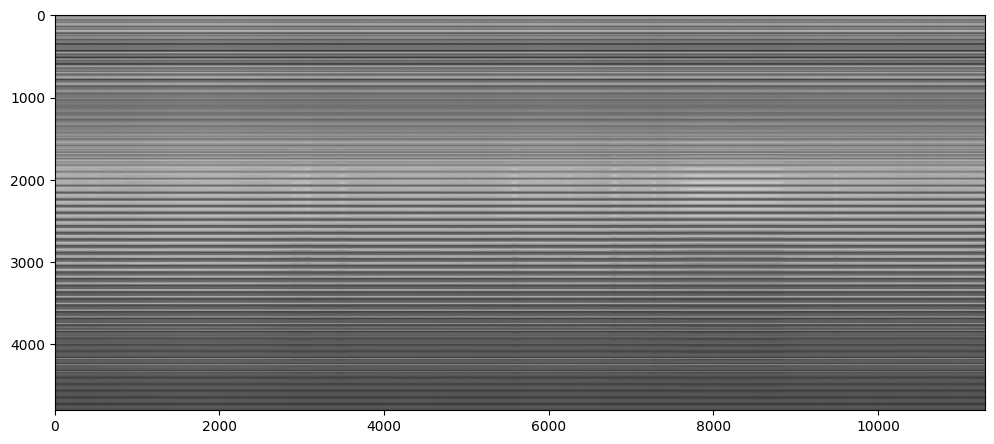

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

The below images were created with high-res data.  Very slow to process:

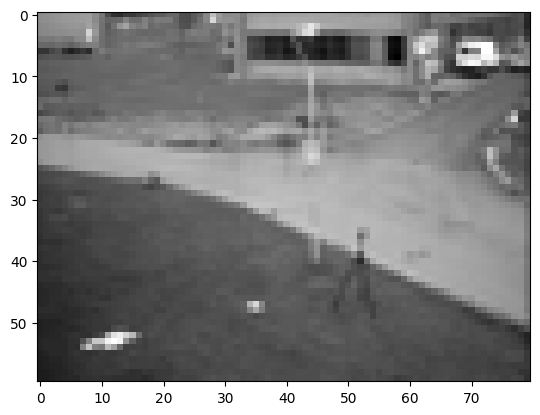

In [ ]:
plt.imshow(np.reshape(low_rank[:,140], dims), cmap='gray');

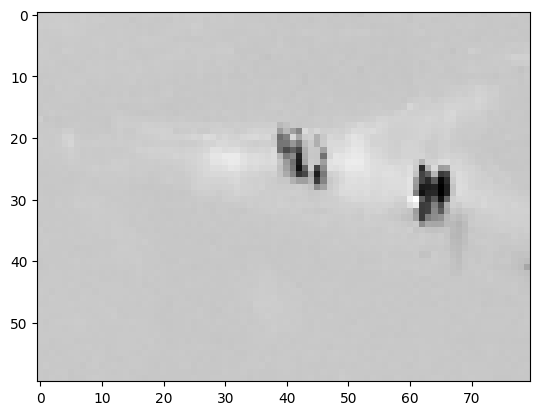

In [ ]:
plt.imshow(np.reshape(M[:,550] - low_rank[:,550], dims), cmap='gray');

#### Rank 1 Approximation

In [ ]:
u, s, v = decomposition.randomized_svd(M, 1)

In [ ]:
u.shape, s.shape, v.shape

((4800, 1), (1,), (1, 11300))

In [ ]:
low_rank = u @ np.diag(s) @ v

In [ ]:
low_rank.shape

(4800, 11300)

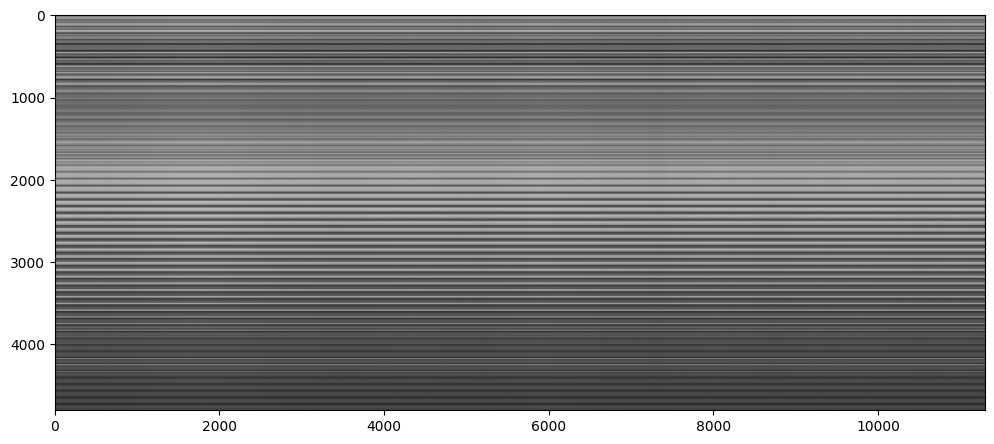

In [ ]:
plt.figure(figsize=(12, 12))
plt.imshow(low_rank, cmap='gray')

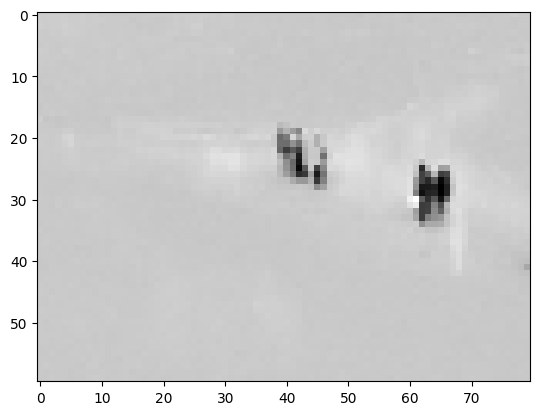

In [ ]:
plt.imshow(np.reshape(M[:,550] - low_rank[:,550], dims), cmap='gray');

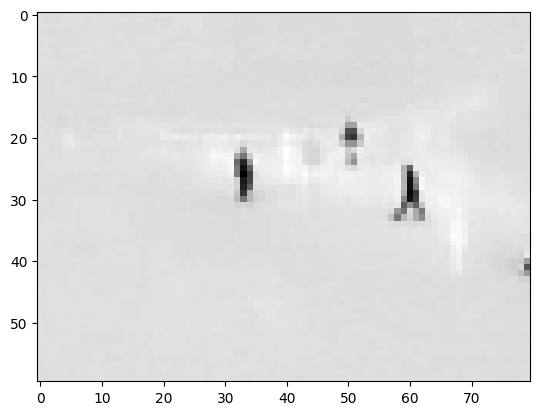

In [ ]:
plt.imshow(np.reshape(M[:,140] - low_rank[:,140], dims), cmap='gray');

Let's zoom in on the people:

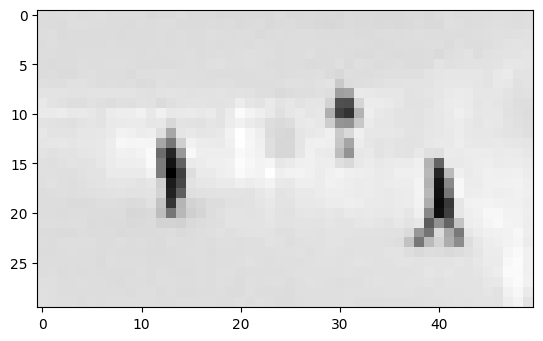

In [ ]:
plt.imshow(np.reshape(M[:,140] - low_rank[:,140], dims)[10:40,20:70], cmap='gray');


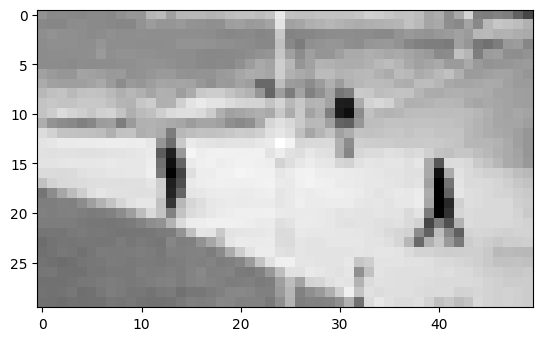

In [ ]:
plt.imshow(np.reshape(M[:,140], dims)[10:40,20:70], cmap='gray')

## Exercises:









  axs[0].set_title('$\mathbf{A}$\nThe matrix')

  axs[1].set_title('$\mathbf{U}$\n(left singular vects)')

  axs[2].set_title('$\mathbf{\Sigma}$\n(singular vals)')

  axs[3].set_title('$\mathbf{V}$\n(right singular vects)')



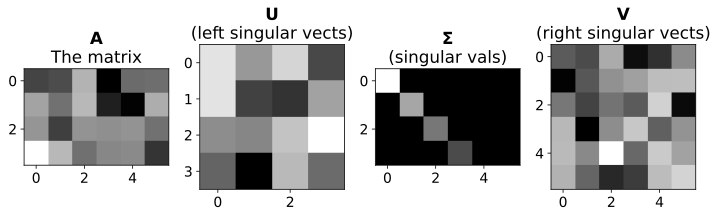

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# NOTE: these lines define global figure properties used for publication.
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg') # display figures in vector format
plt.rcParams.update({'font.size':14}) # set global font size



A = np.random.randn(4,6)

# its SVD
U,s,Vt = np.linalg.svd(A)

# create Sigma from sigma's
S = np.zeros(np.shape(A))
np.fill_diagonal(S,s)


# show the matrices
_,axs = plt.subplots(1,4,figsize=(10,6))

axs[0].imshow(A,cmap='gray',aspect='equal')
axs[0].set_title('$\mathbf{A}$\nThe matrix')

axs[1].imshow(U,cmap='gray',aspect='equal')
axs[1].set_title('$\mathbf{U}$\n(left singular vects)')

axs[2].imshow(S,cmap='gray',aspect='equal')
axs[2].set_title('$\mathbf{\Sigma}$\n(singular vals)')

axs[3].imshow(Vt,cmap='gray',aspect='equal')
axs[3].set_title('$\mathbf{V}$\n(right singular vects)')

plt.tight_layout()
plt.savefig('Figure_14_02.png',dpi=300)
plt.show()


In [ ]:
A = np.random.randn(5,5)
A = A.T@A

# extract eigenvalues and singular values
eigvals = np.linalg.eig(A)[0]
sinvals = np.linalg.svd(A)[1]

# they're the same!
print(np.sort(eigvals))
print(np.sort(sinvals))

[ 0.03491186  0.84560137  1.6918243   4.92618709 13.14215922]
[ 0.03491186  0.84560137  1.6918243   4.92618709 13.14215922]


In [ ]:
# create a symmetric matrix
A = np.random.randn(5,5)
A = A.T@A
# A = A+A.T # uncomment this line to repeat for A+A'

# eigendecomposition
evals,evecs = np.linalg.eig(A)

# sorting them helps the comparison!
sidx  = np.argsort(evals)[::-1]
evals = evals[sidx]
evecs = evecs[:,sidx]



# SVD
U,s,Vt = np.linalg.svd(A)

# compare the eigenvalues and singular values
print('Eigenvalues and singular values:')
print(np.vstack((evals,s)).T)

# now compare the left and right singular vectors
print(f'\nLeft-Right singular vectors (should be zeros)')
print(np.round(U-Vt.T,10)) # remember to compare V not V^T!

# then compare singular vectors with eigenvectors
print(f'\nSingular vectors - eigenvectors (should be zeros)')
print(np.round(U-evecs,10)) # subtract and
print(' ')
print(np.round(U+evecs,10)) # add for sign indeterminancy

Eigenvalues and singular values:
[[14.90469934 14.90469934]
 [ 6.53674433  6.53674433]
 [ 4.15355377  4.15355377]
 [ 0.08951503  0.08951503]
 [ 0.03128663  0.03128663]]

Left-Right singular vectors (should be zeros)
[[ 0. -0. -0.  0.  0.]
 [-0.  0.  0.  0. -0.]
 [ 0. -0. -0. -0.  0.]
 [ 0.  0.  0. -0.  0.]
 [-0. -0.  0.  0.  0.]]

Singular vectors - eigenvectors (should be zeros)
[[ 0.         -1.68870973 -0.53962237  0.29531075 -0.        ]
 [ 0.          0.24496158 -0.52318485  0.62497471 -0.        ]
 [ 0.         -0.07519261 -1.02476803 -1.67865706  0.        ]
 [ 0.         -0.79164731  1.4754668  -0.68755378  0.        ]
 [-0.          0.67519913  0.45599728 -0.48122599  0.        ]]
 
[[-0.46429998 -0.          0.          0.          0.74450267]
 [ 1.56694891  0.         -0.          0.          0.90573128]
 [ 0.35441184 -0.          0.         -0.         -0.02644366]
 [ 0.84731804  0.          0.          0.          0.07492807]
 [-0.69680774 -0.         -0.          0.      

In [ ]:
# sizes (try tall and wide)
m = 10
n = 4

# random matrix and its economy (aka reduced) SVD
A = np.random.randn(m,n)
U,s,Vt = np.linalg.svd(A,full_matrices=False)

# print sizes
print(f'Size of A:  {A.shape}')
print(f'Size of U:  {U.shape}')
print(f"Size of V': {Vt.shape}")

Size of A:  (10, 4)
Size of U:  (10, 4)
Size of V': (4, 4)




  axs[2].set_title(f'$\Sigma$ (cond={np.linalg.cond(S):.3f})')



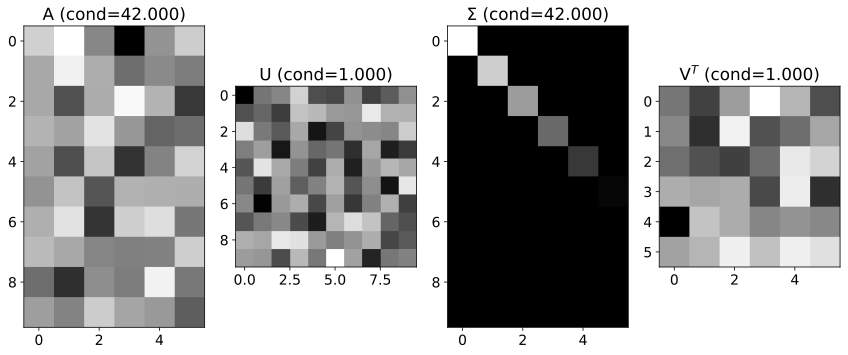

In [93]:
# create a tall matrix with specified condition number
m = 10
n = 6

condnum = 42

# create U and V from random numbers
U,_  = np.linalg.qr( np.random.randn(m,m) )
Vt,_ = np.linalg.qr( np.random.randn(n,n) )

# create singular values vector
s = np.linspace(condnum,1,np.min((m,n)))

# convert into a matrix
S = np.zeros((m,n))
np.fill_diagonal(S,s)

# create matrix
A = U@S@Vt

# and show in a plot
_,axs = plt.subplots(1,4,figsize=(12,6))

axs[0].imshow(A, aspect='equal', cmap='gray')
axs[0].set_title(f'A (cond={np.linalg.cond(A):.3f})')

axs[1].imshow(U, aspect='equal', cmap='gray')
axs[1].set_title(f'U (cond={np.linalg.cond(U):.3f})')

axs[2].imshow(S, aspect='equal', cmap='gray')
axs[2].set_title(f'$\Sigma$ (cond={np.linalg.cond(S):.3f})')

axs[3].imshow(Vt, aspect='equal', cmap='gray')
axs[3].set_title(f'V$^T$ (cond={np.linalg.cond(Vt):.3f})')


plt.tight_layout()
plt.savefig('Figure_14_04.png',dpi=300)
plt.show()



  axs[2].set_title('$\Sigma$')



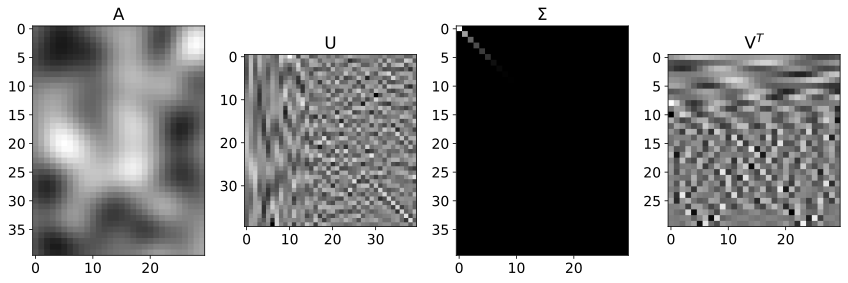

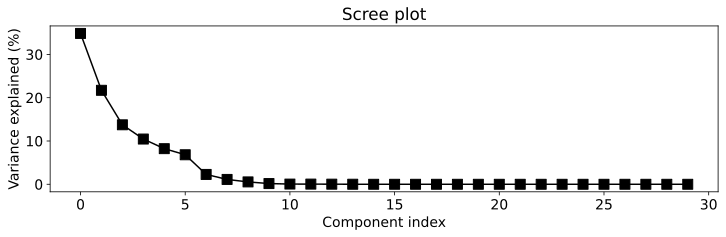

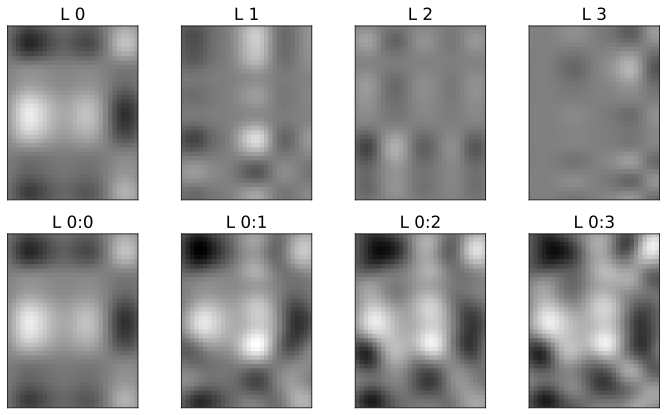

In [95]:
# create the matrix
m = 40
n = 30

# define a 2D Gaussian for smoothing
k = int((m+n)/4)
X,Y = np.meshgrid(np.linspace(-3,3,k),np.linspace(-3,3,k))
g2d = np.exp( -(X**2 + Y**2)/(k/8) )


# now for the matrix
from scipy.signal import convolve2d
A = convolve2d(np.random.randn(m,n),g2d,mode='same')


# SVD and create Sigma
U,s,Vt = np.linalg.svd(A)
S = np.zeros(np.shape(A))
np.fill_diagonal(S,s)


# visualize the matrices

# and show in a plot
_,axs = plt.subplots(1,4,figsize=(12,6))

axs[0].imshow(A, aspect='equal', cmap='gray', vmin=-10,vmax=10)
axs[0].set_title('A')

axs[1].imshow(U, aspect='equal', cmap='gray')
axs[1].set_title('U')

axs[2].imshow(S, aspect='equal', cmap='gray')
axs[2].set_title('$\Sigma$')

axs[3].imshow(Vt, aspect='equal', cmap='gray')
axs[3].set_title('V$^T$')


plt.tight_layout()
plt.savefig('Figure_14_05a.png',dpi=300)
plt.show()


# and show the scree plot
plt.figure(figsize=(12,3))
plt.plot(100*s/np.sum(s),'ks-',markersize=10)
plt.xlabel('Component index')
plt.ylabel('Variance explained (%)')
plt.title('Scree plot')
plt.savefig('Figure_14_05b.png',dpi=300)
plt.show()

## now show the first N "layers" separately and summed

numLayers = 4
rank1mats = np.zeros((numLayers,m,n))


# setup the figure
_,axs = plt.subplots(2,numLayers,figsize=(10,6))

# the loop
for i in range(numLayers):

    # create this layer
    rank1mats[i,:,:] = np.outer(U[:,i],Vt[i,:])*S[i,i]

    # show this layer
    axs[0,i].imshow(rank1mats[i,:,:],cmap='gray', vmin=-10,vmax=10)
    axs[0,i].set_title(f'L {i}')
    axs[0,i].set_xticks([]), axs[0,i].set_yticks([])

    # show the cumulative sum of layers
    axs[1,i].imshow(np.sum(rank1mats[:i+1,:,:],axis=0),cmap='gray', vmin=-10,vmax=10)
    axs[1,i].set_title(f'L 0:{i}')
    axs[1,i].set_xticks([]), axs[1,i].set_yticks([])


plt.tight_layout()
plt.savefig('Figure_14_05c.png',dpi=300)
plt.show()

## Principal Component Analysis (PCA)